In [2]:
import os, random

import numpy as np
import tensorflow as tf

from sys import path
from PIL import Image
from scipy.ndimage import imread
from scipy.misc import imresize
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve, auc

code_dir = os.path.join(os.path.abspath("."), "Functions")
path.append(code_dir)
data_dir = './PreProcessed/'

import InterfacePreprocessing as IntPre
import importFunctions as iF

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [30]:
global raw_only, image_size, num_layer
raw_only = False
raw_image_size = 150
image_size= 88

if raw_only:
    num_layer = 1
else:
    num_layer = 6

p_matching = 0.5
num_filter_1 = 20
num_filter_2 = 40
num_filter_3 = 60

In [4]:
def weight_variable(shape, name_str):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = name_str)

def bias_variable(shape, name_str):
    initial = tf.constant(0.3, shape=shape)
    return tf.Variable(initial, name = name_str)

def conv2d(x, W, stride=[1, 1, 1, 1]):
    return tf.nn.conv2d(x, W, strides=stride, padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [5]:
# Smaller Dataset for testing/validation
images_match_small, images_mismatch_small = iF.load_pairs_from_preprocessed("../Fingerprint_Data/Processed_Full_CASIA/Match/", 
                                                                            "../Fingerprint_Data/Processed_Full_CASIA/MisMatch/", 
                                                                            image_size, num_layer, False)

# Full Dataset
# images_match, images_mismatch = iF.load_pairs_from_preprocessed("../Fingerprint_Data/Processed_Full_CASIA/Match/", 
#                                                                 "../Fingerprint_Data/Processed_Full_CASIA/MisMatch/", 
#                                                                 image_size, num_layer, False)

images_match, images_mismatch = iF.load_pairs_from_preprocessed("../Fingerprint_Data/Processed_Full_CASIA/Match/", 
                                                                "../Fingerprint_Data/Processed_Full_CASIA/MisMatch/", 
                                                                image_size, num_layer, False)

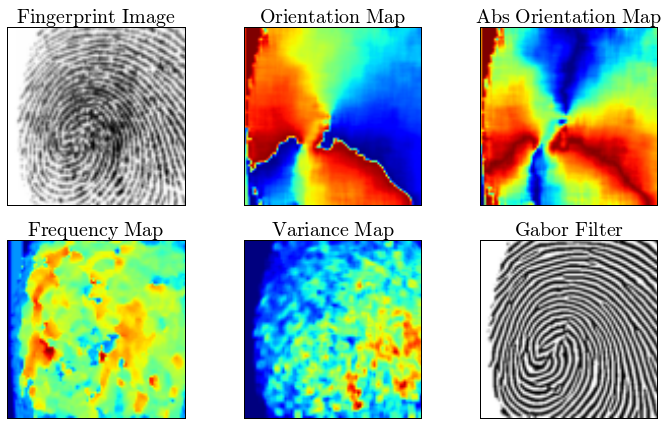

In [6]:
import matplotlib.pyplot as plt
% matplotlib inline

key = images_match.keys()[16]
fig = plt.figure(figsize=(12, 7))

plt.subplot(2,3,1)
plt.imshow(images_match[key][:,:,0],cmap = 'gray')  
plt.title(r'$\mathrm{Fingerprint \ Image}$', fontsize = 20)
plt.xticks([]), plt.yticks([])

plt.subplot(2,3,2)
plt.imshow(images_match[key][:,:,2],cmap = 'jet')  
plt.title(r'$\mathrm{Orientation \ Map}$', fontsize = 20)
plt.xticks([]), plt.yticks([])

plt.subplot(2,3,3)
plt.imshow(images_match[key][:,:,3],cmap = 'jet')  
plt.title(r'$\mathrm{Abs \ Orientation \ Map}$', fontsize = 20)
plt.xticks([]), plt.yticks([])

plt.subplot(2,3,4)
plt.imshow(images_match[key][:,:,1],cmap = 'jet')  
plt.title(r'$\mathrm{Frequency \ Map}$', fontsize = 20)
plt.xticks([]), plt.yticks([])

plt.subplot(2,3,5)
plt.imshow(images_match[key][:,:,4],cmap = 'jet')  
plt.title(r'$\mathrm{Variance \ Map}$', fontsize = 20)
plt.xticks([]), plt.yticks([])

plt.subplot(2,3,6)
plt.imshow(images_match[key][:,:,5],cmap = 'gray')  
plt.title(r'$\mathrm{Gabor \ Filter}$', fontsize = 20)
plt.xticks([]), plt.yticks([]);

fig.savefig('demo.pdf')

In [26]:
global raw_only, image_size, num_layer
raw_only = True
raw_image_size = 150
image_size= 88

if raw_only:
    num_layer = 1
else:
    num_layer = 6

p_matching = 0.5
num_filter_1 = 20
num_filter_2 = 40
num_filter_3 = 60

In [32]:
# These two are input images
x = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])
x_p = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])

# y_ is just a value 0(match) or 1(no match) for the two input images
y_ = tf.placeholder(tf.float32, shape=[None, 1])

# Dropout coefficient
keep_prob = tf.placeholder(tf.float32)

W_conv1 = weight_variable([7, 7, num_layer, num_filter_1],'W_conv1')
b_conv1 = bias_variable([num_filter_1],'b_conv1')

W_conv2 = weight_variable([5, 5, num_filter_1, num_filter_2],'W_conv2')
b_conv2 = bias_variable([num_filter_2],'b_conv2')

W_conv3 = weight_variable([5, 5, num_filter_2, num_filter_3],'W_conv3')
b_conv3 = bias_variable([num_filter_3],'b_conv3')

W_conv1_p = weight_variable([7, 7, num_layer, num_filter_1],'W_conv1_p')
b_conv1_p = bias_variable([num_filter_1],'b_conv1_p')

W_conv2_p = weight_variable([5, 5, num_filter_1, num_filter_2],'W_conv2_p')
b_conv2_p = bias_variable([num_filter_2],'b_conv2_p')

W_conv3_p = weight_variable([5, 5, num_filter_2, num_filter_3],'W_conv3_p')
b_conv3_p = bias_variable([num_filter_3],'b_conv3_p')

W_fc1 = weight_variable([image_size/8*image_size/8*num_filter_3, 1024],'W_fc1')
b_fc1 = bias_variable([1024],'b_fc1')

W_fc2 = weight_variable([1024, 2],'W_fc2')
b_fc2 = bias_variable([2],'b_fc2')

In [33]:
# Input Image
x_image = tf.reshape(x, [-1,image_size,image_size,num_layer])

# First Conv Layer - after maxpool 44*44
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second Conv Layer - after maxpool 22*22
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Third Conv Layer - after maxpool 11*11
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# Final Data Processing Step
z = tf.reshape(h_pool3, [-1,image_size/8*image_size/8*num_filter_3])
z_norm = tf.pow(tf.reduce_sum(tf.pow(z, 2), reduction_indices=1),0.5)

h_fc1 = tf.nn.relu(tf.matmul(z, W_fc1) + b_fc1)
h_fc1_norm = tf.sqrt(tf.reduce_sum(tf.square(h_fc1)))
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# ############### #
#      Side 2     #
# ############### #

# Input Image
x_image_p = tf.reshape(x_p, [-1,image_size,image_size,num_layer])

# First Conv Layer - after maxpool 44*44
h_conv1_p = tf.nn.relu(conv2d(x_image_p, W_conv1_p) + b_conv1_p)
h_pool1_p = max_pool_2x2(h_conv1_p)

# Second Conv Layer - after maxpool 22*22
h_conv2_p = tf.nn.relu(conv2d(h_pool1_p, W_conv2_p) + b_conv2_p)
h_pool2_p = max_pool_2x2(h_conv2_p)

# Third Conv Layer - after maxpool 11*11
h_conv3_p = tf.nn.relu(conv2d(h_pool2_p, W_conv3_p) + b_conv3_p)
h_pool3_p = max_pool_2x2(h_conv3_p)

# Final Data Processing Step
z_p = tf.reshape(h_pool3_p, [-1,image_size/8*image_size/8*num_filter_3])
z_p_norm = tf.sqrt(tf.reduce_sum(tf.square(z_p), reduction_indices=1))

h_fc1_p = tf.nn.relu(tf.matmul(z_p, W_fc1) + b_fc1)
h_fc1_p_norm = tf.sqrt(tf.reduce_sum(tf.square(h_fc1_p)))
h_fc1_p_drop = tf.nn.dropout(h_fc1, keep_prob)

y_conv_p=tf.nn.softmax(tf.matmul(h_fc1_p_drop, W_fc2) + b_fc2)

# Frequent Output for Testing that writes to log file

In [11]:
# # Distance calcualted using pre-fc layer 
# abs_dist = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)
# distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))

# Distance calculated using fc layer output
distance = tf.mul(tf.div(tf.reduce_sum(h_fc1 * h_fc1_p, reduction_indices=1), h_fc1_norm * h_fc1_p_norm), tf.transpose(y_))
abs_dist = tf.div(tf.reduce_sum(h_fc1 * h_fc1_p, reduction_indices=1), h_fc1_norm * h_fc1_p_norm)

cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

auc_list = []

saver = tf.train.Saver({"W1": W_conv1, "W2": W_conv2,"W3": W_conv3,
                        "b1": b_conv1,"b2": b_conv2,"b3": b_conv3,
                        "W1_p": W_conv1_p, "W2_p": W_conv2_p,"W3_p": W_conv3_p,
                        "b1_p": b_conv1_p,"b2_p": b_conv2_p,"b3_p": b_conv3_p,
                        "W_fc1": W_fc1, "b_fc1": b_fc1,
                        "W_fc2": W_fc2, "b_fc2": b_fc2})

init_op = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init_op)
    distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))
    cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)
    sess.run(tf.initialize_all_variables())
    
    f = open('log.txt', 'w+')
    
    for i in range(1000):
        batch = iF.generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 50, image_size, num_layer)

        if i % 50 == 0:
            auc_batch = iF.generate_batch_pairs_from_preprocessed(images_match_small, images_mismatch_small, 50, image_size, num_layer)
            d =  abs_dist.eval(feed_dict={x:auc_batch[0], x_p:auc_batch[1], y_: auc_batch[2], keep_prob: 1.0})
            fpr, tpr, _ = roc_curve(auc_batch[2], d.T)
            roc_auc = auc(fpr, tpr)
            auc_list.append(roc_auc)
            str1 =  'Iteration '+ str(i) 
            str2 =  ' AUC: %.2f'% roc_auc + \
                    ' Loss: ' + \
                    str(cross_entropy.eval(feed_dict={x:auc_batch[0], 
                                                      x_p:auc_batch[1], 
                                                      y_: auc_batch[2], 
                                                      keep_prob: 1.0})[0])
            str3 =  ' Distance: ' + \
                    str(((d[1:6]*100).astype(int)).astype(float)/100) + \
                    ' Labels: '+ str((auc_batch[2][1:6].T).astype(int))
                    
            save_path = saver.save(sess, "training_" + str(i) + ".ckpt")
            f.write(str1 + str2+ str3 + '\n')
            
            f2 = open('progress.txt', 'w+')
            f2.write(str1 + str2+ str3 + '\n')
            f2.close
            
        train_step.run(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
        
    f.close()

Iteration 0 AUC: 0.58 Loss: -10.4182 Distance: [ 0.01  0.01  0.    0.    0.01] Labels: [[0 0 0 0 0]]
Iteration 1 AUC: 0.62 Loss: -11.2365 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 2 AUC: 0.55 Loss: -11.6137 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 3 AUC: 0.49 Loss: -12.522 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 4 AUC: 0.62 Loss: -13.0269 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 5 AUC: 0.62 Loss: -13.7669 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 6 AUC: 0.67 Loss: -14.5959 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 7 AUC: 0.63 Loss: -15.0091 Distance: [ 0.01  0.01  0.01  0.01  0.02] Labels: [[0 0 0 0 0]]
Iteration 8 AUC: 0.68 Loss: -15.7008 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 9 AUC: 0.69 Loss: -16.0818 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0

# A good run

In [1]:
# # Distance calcualted using pre-fc layer 
# abs_dist = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)
# distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))

# Distance calculated using fc layer output
distance = tf.mul(tf.div(tf.reduce_sum(h_fc1 * h_fc1_p, reduction_indices=1), h_fc1_norm * h_fc1_p_norm), tf.transpose(y_))
abs_dist = tf.div(tf.reduce_sum(h_fc1 * h_fc1_p, reduction_indices=1), h_fc1_norm * h_fc1_p_norm)

cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

auc_list = []

saver = tf.train.Saver({"W1": W_conv1, "W2": W_conv2,"W3": W_conv3,
                        "b1": b_conv1,"b2": b_conv2,"b3": b_conv3,
                        "W1_p": W_conv1_p, "W2_p": W_conv2_p,"W3_p": W_conv3_p,
                        "b1_p": b_conv1_p,"b2_p": b_conv2_p,"b3_p": b_conv3_p,
                        "W_fc1": W_fc1, "b_fc1": b_fc1,
                        "W_fc2": W_fc2, "b_fc2": b_fc2})

init_op = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init_op)
    distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))
    cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)
    sess.run(tf.initialize_all_variables())
    
    for i in range(1000):
        batch = iF.generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 25, image_size, num_layer)

        if i % 50 == 0:
            auc_batch = iF.generate_batch_pairs_from_preprocessed(images_match_small, images_mismatch_small, 50, image_size, num_layer)
            d =  abs_dist.eval(feed_dict={x:auc_batch[0], x_p:auc_batch[1], y_: auc_batch[2], keep_prob: 1.0})
            fpr, tpr, _ = roc_curve(auc_batch[2], d.T)
            roc_auc = auc(fpr, tpr)
            auc_list.append(roc_auc)
            str1 =  'Iteration '+ str(i) 
            str2 =  ' AUC: %.2f'% roc_auc + \
                    ' Loss: ' + \
                    str(cross_entropy.eval(feed_dict={x:auc_batch[0], 
                                                      x_p:auc_batch[1], 
                                                      y_: auc_batch[2], 
                                                      keep_prob: 1.0})[0])
            str3 =  ' Distance: ' + \
                    str(((d[1:6]*100).astype(int)).astype(float)/100) + \
                    ' Labels: '+ str((auc_batch[2][1:6].T).astype(int))
                    
            print str1+str2+str3
            
        train_step.run(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
        

Iteration 0 AUC: 0.64 Loss: -10.9834 Distance: [ 0.01  0.01  0.01  0.    0.  ] Labels: [[0 1 0 1 1]]
Iteration 50 AUC: 0.65 Loss: -20.4081 Distance: [ 0.01  0.02  0.01  0.02  0.01] Labels: [[1 0 0 1 0]]
Iteration 100 AUC: 0.81 Loss: -19.7682 Distance: [ 0.02  0.01  0.02  0.01  0.01] Labels: [[0 1 1 0 0]]
Iteration 150 AUC: 0.80 Loss: -17.0448 Distance: [ 0.01  0.01  0.    0.05  0.01] Labels: [[1 1 0 1 1]]
Iteration 200 AUC: 0.86 Loss: -11.1451 Distance: [ 0.  0.  0.  0.  0.] Labels: [[0 0 1 1 0]]
Iteration 250 AUC: 0.86 Loss: -12.4478 Distance: [ 0.  0.  0.  0.  0.] Labels: [[0 1 0 0 0]]


# Frequent Output for Testing

In [13]:
# # Distance calcualted using pre-fc layer 
# abs_dist = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)
# distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))

# Distance calculated using fc layer output
distance = tf.mul(tf.div(tf.reduce_sum(h_fc1 * h_fc1_p, reduction_indices=1), h_fc1_norm * h_fc1_p_norm), tf.transpose(y_))
abs_dist = tf.div(tf.reduce_sum(h_fc1 * h_fc1_p, reduction_indices=1), h_fc1_norm * h_fc1_p_norm)

cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

auc_list = []

saver = tf.train.Saver({"W1": W_conv1, "W2": W_conv2,"W3": W_conv3,
                        "b1": b_conv1,"b2": b_conv2,"b3": b_conv3,
                        "W1_p": W_conv1_p, "W2_p": W_conv2_p,"W3_p": W_conv3_p,
                        "b1_p": b_conv1_p,"b2_p": b_conv2_p,"b3_p": b_conv3_p,
                        "W_fc1": W_fc1, "b_fc1": b_fc1,
                        "W_fc2": W_fc2, "b_fc2": b_fc2})

init_op = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init_op)
    distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))
    cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)
    sess.run(tf.initialize_all_variables())
    
    for i in range(30):
        batch = iF.generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 75, image_size, num_layer)

        if i % 1 == 0:
            auc_batch = iF.generate_batch_pairs_from_preprocessed(images_match_small, images_mismatch_small, 50, image_size, num_layer)
            d =  abs_dist.eval(feed_dict={x:auc_batch[0], x_p:auc_batch[1], y_: auc_batch[2], keep_prob: 1.0})
            fpr, tpr, _ = roc_curve(auc_batch[2], d.T)
            roc_auc = auc(fpr, tpr)
            auc_list.append(roc_auc)
            str1 =  'Iteration '+ str(i) 
            str2 =  ' AUC: %.2f'% roc_auc + \
                    ' Loss: ' + \
                    str(cross_entropy.eval(feed_dict={x:auc_batch[0], 
                                                      x_p:auc_batch[1], 
                                                      y_: auc_batch[2], 
                                                      keep_prob: 1.0})[0])
            str3 =  ' Distance: ' + \
                    str(((d[1:6]*100).astype(int)).astype(float)/100) + \
                    ' Labels: '+ str((auc_batch[2][1:6].T).astype(int))
                    
            print str1+str2+str3
            
        train_step.run(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
        

Iteration 0 AUC: 0.63 Loss: -9.07895 Distance: [ 0.01  0.01  0.01  0.    0.01] Labels: [[0 0 0 0 0]]
Iteration 1 AUC: 0.65 Loss: -9.9327 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 2 AUC: 0.54 Loss: -10.5605 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 3 AUC: 0.63 Loss: -11.1493 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 4 AUC: 0.46 Loss: -11.8124 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 5 AUC: 0.44 Loss: -12.2945 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 6 AUC: 0.60 Loss: -13.0023 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 7 AUC: 0.62 Loss: -13.771 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 8 AUC: 0.48 Loss: -14.3911 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 0]]
Iteration 9 AUC: 0.58 Loss: -14.8705 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 

# Try to reproduce good run

In [13]:
# # Distance calcualted using pre-fc layer 
# abs_dist = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)
# distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))

# Distance calculated using fc layer output
distance = tf.mul(tf.div(tf.reduce_sum(h_fc1 * h_fc1_p, reduction_indices=1), h_fc1_norm * h_fc1_p_norm), tf.transpose(y_))
abs_dist = tf.div(tf.reduce_sum(h_fc1 * h_fc1_p, reduction_indices=1), h_fc1_norm * h_fc1_p_norm)

cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

auc_list = []

saver = tf.train.Saver({"W1": W_conv1, "W2": W_conv2,"W3": W_conv3,
                        "b1": b_conv1,"b2": b_conv2,"b3": b_conv3,
                        "W1_p": W_conv1_p, "W2_p": W_conv2_p,"W3_p": W_conv3_p,
                        "b1_p": b_conv1_p,"b2_p": b_conv2_p,"b3_p": b_conv3_p,
                        "W_fc1": W_fc1, "b_fc1": b_fc1,
                        "W_fc2": W_fc2, "b_fc2": b_fc2})

init_op = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init_op)
    distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))
    cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)
    sess.run(tf.initialize_all_variables())
    
    for i in range(1000):
        batch = iF.generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 25, image_size, num_layer)

        if i % 50 == 0:
            auc_batch = iF.generate_batch_pairs_from_preprocessed(images_match_small, images_mismatch_small, 50, image_size, num_layer)
            d =  abs_dist.eval(feed_dict={x:auc_batch[0], x_p:auc_batch[1], y_: auc_batch[2], keep_prob: 1.0})
            fpr, tpr, _ = roc_curve(auc_batch[2], d.T)
            roc_auc = auc(fpr, tpr)
            auc_list.append(roc_auc)
            str1 =  'Iteration '+ str(i) 
            str2 =  ' AUC: %.2f'% roc_auc + \
                    ' Loss: ' + \
                    str(cross_entropy.eval(feed_dict={x:auc_batch[0], 
                                                      x_p:auc_batch[1], 
                                                      y_: auc_batch[2], 
                                                      keep_prob: 1.0})[0])
            str3 =  ' Distance: ' + \
                    str(((d[1:6]*100).astype(int)).astype(float)/100) + \
                    ' Labels: '+ str((auc_batch[2][1:6].T).astype(int))
                    
            print str1+str2+str3
            
        train_step.run(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
        

Iteration 0 AUC: 0.54 Loss: -8.913 Distance: [ 0.01  0.01  0.    0.01  0.  ] Labels: [[1 1 0 1 1]]
Iteration 50 AUC: 0.70 Loss: -20.136 Distance: [ 0.01  0.01  0.01  0.01  0.01] Labels: [[0 0 0 0 1]]
Iteration 100 AUC: 0.62 Loss: -19.5711 Distance: [ 0.01  0.01  0.02  0.01  0.01] Labels: [[0 0 1 1 1]]
Iteration 150 AUC: 0.76 Loss: -16.7712 Distance: [ 0.01  0.01  0.02  0.01  0.02] Labels: [[0 0 1 1 1]]
Iteration 200 AUC: 0.80 Loss: -9.10964 Distance: [ 0.    0.    0.12  0.    0.  ] Labels: [[0 0 1 1 0]]
Iteration 250 AUC: 0.81 Loss: -9.87799 Distance: [ 0.  0.  0.  0.  0.] Labels: [[1 0 1 0 0]]
Iteration 300 AUC: 0.87 Loss: -10.2094 Distance: [ 0.  0.  0.  0.  0.] Labels: [[0 0 1 1 0]]
Iteration 350 AUC: 0.89 Loss: -10.8489 Distance: [ 0.    0.    0.    0.16  0.19] Labels: [[1 1 0 1 1]]
Iteration 400 AUC: 0.95 Loss: -10.6883 Distance: [ 0.24  0.03  0.    0.    0.  ] Labels: [[1 1 0 0 1]]
Iteration 450 AUC: 0.88 Loss: -10.4022 Distance: [ 0.02  0.    0.04  0.01  0.  ] Labels: [[1 0 1 0 

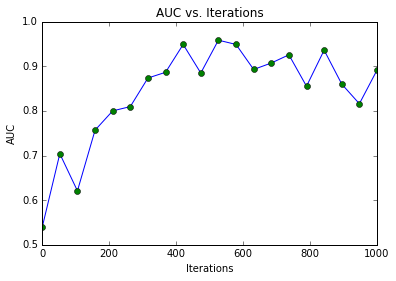

In [19]:
plt.plot(np.linspace(0,1000,20), auc_list)
plt.plot(np.linspace(0,1000,20), auc_list,'o')
plt.title('AUC vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('AUC')

# Try use Pearson R for metrics

In [45]:
# Distance calculated using fc layer output
# 50,1024
mean = tf.sub(h_fc1, tf.reduce_mean(h_fc1, reduction_indices=1, keep_dims=True))
mean_p = tf.sub(h_fc1_p, tf.reduce_mean(h_fc1_p, reduction_indices=1, keep_dims=True))
# 50,1
r_num = tf.reduce_sum(tf.mul(mean, mean_p), reduction_indices=1, keep_dims=True)
r_dnom = tf.sqrt(tf.reduce_sum(tf.mul(tf.pow(mean, 2), tf.pow(mean_p,2)), reduction_indices=1, keep_dims=True))
r = -tf.abs(tf.div(r_num, r_dnom))
cross_entropy = tf.reduce_sum(r)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

auc_list = []

saver = tf.train.Saver({"W1": W_conv1, "W2": W_conv2,"W3": W_conv3,
                        "b1": b_conv1,"b2": b_conv2,"b3": b_conv3,
                        "W1_p": W_conv1_p, "W2_p": W_conv2_p,"W3_p": W_conv3_p,
                        "b1_p": b_conv1_p,"b2_p": b_conv2_p,"b3_p": b_conv3_p,
                        "W_fc1": W_fc1, "b_fc1": b_fc1,
                        "W_fc2": W_fc2, "b_fc2": b_fc2})

init_op = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init_op)
    distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))
    cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)
    sess.run(tf.initialize_all_variables())
    
    for i in range(11):
        batch = iF.generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 25, image_size, num_layer)

        if i % 2 == 0:
            auc_batch = iF.generate_batch_pairs_from_preprocessed(images_match_small, images_mismatch_small, 50, image_size, num_layer)
            d =  r.eval(feed_dict={x:auc_batch[0], x_p:auc_batch[1], y_: auc_batch[2], keep_prob: 1.0})
            fpr, tpr, _ = roc_curve(auc_batch[2], d)
            roc_auc = auc(fpr, tpr)
            auc_list.append(roc_auc)
            str1 =  'Iteration '+ str(i) 
            str2 =  ' AUC: %.2f'% roc_auc + \
                    ' Loss: ' + \
                    str(cross_entropy.eval(feed_dict={x:auc_batch[0], 
                                                      x_p:auc_batch[1], 
                                                      y_: auc_batch[2], 
                                                      keep_prob: 1.0})[0])
            str3 =  ' Distance: ' + \
                    str(((d[1:6]*100).astype(int)).astype(float)/100) + \
                    ' Labels: '+ str((auc_batch[2][1:6].T).astype(int))
                    
            print str1+str2+str3
            
        train_step.run(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
        

Iteration 0 AUC: 0.58 Loss: -7.87747 Distance: [[-6.74]
 [-6.69]
 [-6.47]
 [-6.32]
 [-6.74]] Labels: [[0 0 0 1 1]]
Iteration 2 AUC: 0.57 Loss: -9.51041 Distance: [[-10.45]
 [-10.8 ]
 [-10.18]
 [ -9.53]
 [-10.63]] Labels: [[1 0 0 1 0]]
Iteration 4 AUC: 0.44 Loss: -11.1288 Distance: [[-13.22]
 [-14.16]
 [-13.64]
 [-13.22]
 [-13.45]] Labels: [[0 0 0 0 0]]
Iteration 6 AUC: 0.36 Loss: -12.3888 Distance: [[-15.62]
 [-15.01]
 [-15.9 ]
 [-15.73]
 [-15.54]] Labels: [[0 1 1 1 0]]
Iteration 8 AUC: 0.46 Loss: -13.2517 Distance: [[-16.63]
 [-17.6 ]
 [-17.31]
 [-17.99]
 [-17.47]] Labels: [[1 0 1 1 1]]
Iteration 10 AUC: 0.46 Loss: -14.2498 Distance: [[-19.06]
 [-18.76]
 [-19.21]
 [-18.48]
 [-19.26]] Labels: [[0 0 0 1 1]]


In [25]:
num_layer

6